Agnieszka Dutka

# Text algorithms, lab 2
### *Trie vs Tree structure*

Content:
##### Implementation
[Suffix trie](#trie)

[Suffix Tree (McCreight)](#tree) 

[Checker](#checker)
##### Testing and comparison
[Test](#tests)

[Comparision](#comparison)

<a id='trie'></a>
##  --Suffix Trie--

#### Useful structures

In [6]:
class Node:
    idx = -1
    def __init__(self, c, parent=None, depth=0):
        self.c = c
        self.parent = parent
        self.depth = depth
        self.children = {}
        self.link = None
        self.idx = self.next_idx
    
    def child(self, c):
        """ find child with label c """
        return self.children.get(c, None)
        
    def add_child(self, c):
        if c in self.children.keys():
            print("child already exists!")
            return self.children[c]
        self.children[c] = Node(c, self, self.depth+1)
        return self.children[c]
    
    def find(self, word: list):
        """ find word in a trie of which self is root """
        if len(word) == 0:
            return True
        if self.child(word[0]) is None:
            return False
        return self.child(word[0]).find(word[1:])
    
    @property
    def next_idx(self):  
        """ finding unique idx for each node (idx of last-added node = size of trie-1)
        (unless several tries created at once)"""
        if not self.parent:
            Node.idx = -1
        Node.idx += 1
        return Node.idx
    
    def __repr__(self):
        return f"{self.c}-{self.idx}"

#### Suffix Trie implementation

In [7]:
from queue import LifoQueue as queue 

def up_link_down(sibling):
    letters = queue()
    while(sibling and not sibling.link):
        letters.put(sibling.c)
        sibling=sibling.parent
    if(not sibling):
        return(None,None)
    node=sibling.link
    current_letter=letters.get()
    while(current_letter):
        if(node.child(current_letter)):
            node=node.child(current_letter)
            sibling=sibling.child(current_letter)
            sibling.link = node
        else:
            break
        current_letter=letters.get()
    return(node,sibling)

def graft(node, fragment, sibling=None):
#     print(f"adding fragment length {len(fragment)}, {fragment}")
    for letter in list(fragment):
        node = node.add_child(letter)
        if(sibling):
            sibling=sibling.child(letter)
            sibling.link = node
    return node

""" building trie """
def left_to_right(text):
    root = Node("")
    leaf = graft(root, text)
    root.child(text[0]).link = root
    for i in range(1, len(text)):
        head, sibling = up_link_down(leaf)
        leaf = graft(head,text[i+head.depth:],sibling)
        root.child(text[i]).link = root # experimental
    return root


<a id='tree'></a>
## --Suffix Tree--

#### Tree Structure

In [8]:
class TreeNode:
    """ Node of Suffix Tree of text @text, representing indexes [@first, @last) """
    def __init__(self, text, first=0, last=0, parent=None): # defaults for root
        self.first = first
        self.last = last
        self.text = text # whole text
        self.parent = parent
        self.children = {}
        self.slink = None
         
    @property
    def length(self):
        return self.last - self.first       
    
    @property
    def label(self):
        return self.text[self.first : self.last]
    
    def add(self, first: int, last: int):
        child = TreeNode(self.text, first, last, self)
        self.children[self.text[first]] = child # add new child to parent
        return child
    
    def split(self, offset):
        new_parent_last = self.first+offset
        new_parent = TreeNode(self.text, self.first, new_parent_last, self.parent)
        new_parent.children[self.text[new_parent_last]] = self
        self.parent.children[self.text[self.first]] = new_parent # change child
        self.first = new_parent_last
        self.parent = new_parent
        return new_parent
        
    def child(self, c):
        return self.children.get(c, None)
    
    def find(self, word: list):
        if word is None:
            return True
        child = self.child(word[0])
        if child is None:
            return False
        offset = 1
        while offset < min(len(word), child.length):
            if word[offset] != child.label[offset]:
                return False
            offset += 1
        if offset == len(word):
            return True
        return child.find(word[offset:])
    
    def __str__(self, indent=0): # recursive display
        return '%s%s\n%s' % (indent * '  ', self.label, ''.join(
                child.__str__(indent + 1)
                for key, child in sorted(self.children.items())
            )
        )


### McCreight algorithm for building suffix tree

#### slow find

In [9]:
def slow_find(node, first: int, last: int) -> (TreeNode, TreeNode):
    """ inserts [first, last) into suffix tree starting with @node searching letter by letter.
    @node: represents the potential head in each loop. 
    @return: head and added leaf """
    text = node.text
    offset = 0  # where exactly in the current node we are (offset from node.first)
    while node.child(text[first])  is not None: # looking for child with same first char 
        node = node.child(text[first]) # enter the child
        while node.first + offset < node.last and first<len(text): # traverse nodes letters
            if text[first] == text[node.first + offset]:
                offset += 1
                first += 1
            else:  # we're in the middle of the node
                node = node.split(offset) #CHANGED
                leaf = node.add(first, last)
                return node, leaf
        offset = 0
    leaf = node.add(first, last)
    return node, leaf

### Slow McCreight without fast_find

In [10]:
def SlowMcCreight(text):
    text_len = len(text)
    root = TreeNode(text)
    leaf = root.add(0, text_len)
    for curr_i in range(1, text_len):
        slow_find(root, curr_i, text_len)
    return root

### Full McCreight with fast_find

In [11]:
def fast_find(node, first: int , last: int) -> (TreeNode, int):
    """ returns furthest node on path [first, lasts) and length it occupies in this node 
    e.g: given: abaabb path: (ab)(aab)b -> node(aab), length=3"""
    assert node is not None
    text = node.text
    length = last - first
    if length == 0:
        return node, length
    node = node.child(text[first])
    while length > node.length: # skip entire node
        first += node.length
        length -= node.length
        node = node.child(text[first])
    return node, length

def McCreight(text):
    text_len = len(text)
    root = TreeNode(text)
    old_head = root
    leaf = root.add(0, text_len)
    for curr_i in range(1, text_len):
        if old_head == root:    # new suffix to attach = old leaf [1:]
            old_head, leaf = slow_find(root, leaf.first + 1, leaf.last)
            continue
        parent = old_head.parent
        if parent == root:      # find "highest" slink (aX - X) where oldHead = aX
            head_slink, h_len = fast_find(parent, old_head.first + 1, old_head.last)
        else:                   # find some lower slink (B-B)
            head_slink, h_len = fast_find(parent.slink, old_head.first, old_head.last)
        if h_len < head_slink.length: # actual head_slink ends in the middle of current head_slink
            head_slink = head_slink.split(h_len) # CHANGED
            new_head = head_slink
            leaf = new_head.add(leaf.first, leaf.last) # copy leaf 
        else:                   # head_slink is a node and has other children already - traverse children
            new_head, leaf = slow_find(head_slink, leaf.first, leaf.last)
        old_head.slink = head_slink # = head_slink
        old_head = new_head

    return root

<a id='checker'></a>
## --Checker--

In [12]:
from random import random
def check(structure, text, fast=False, w_print=False, name="structure"):
    """ check if given structure contains all (or ~10 randomly chosen if @fast) suffixes from text
    @w_print: print results instead of returning value """
    for i in range(len(text)):
        if fast and random()>(10./len(text)):
            continue
        if not structure.find(text[i:]):
            if w_print:
                print(f"suffix {text[i:]} not found")
                return
            else:
                return False
    if w_print:
        print(f"{name} correct")
    else:
        return True

In [13]:
def quick_check(builder, text, word, expected=True):
    root = builder(text)
    print(root.find(word) == expected)

<a id='tests'></a>
### Some tests

testing if all correct words are present in the structures (or randomly chosen 10 correct words, if text is too long)

In [14]:
text = "s"
trie = left_to_right(text)
tree_fast = McCreight(text)
tree_slow = SlowMcCreight(text)
check(trie, text, False, True, "trie")
check(tree_fast, text,False, True, "tree_fast")
check(tree_slow, text, False, True, "tree_slow")

trie correct
tree_fast correct
tree_slow correct


In [15]:
text = "bffffds"
trie = left_to_right(text)
tree_fast = McCreight(text)
tree_slow = SlowMcCreight(text)
check(trie, text, False, True, "trie")
check(tree_fast, text,False, True, "tree_fast")
check(tree_slow, text, False, True, "tree_slow")

trie correct
tree_fast correct
tree_slow correct


In [11]:
text = "bananas"
trie = left_to_right(text)
tree_fast = McCreight(text)
tree_slow = SlowMcCreight(text)
check(trie, text, False, True, "trie")
check(tree_fast, text,False, True, "tree_fast")
check(tree_slow, text, False, True, "tree_slow")

trie correct
tree_fast correct
tree_slow correct


In [16]:
text = "bancccocbccccnddncnccvvvjdddwddjaanas"*10
text += ";"
trie = left_to_right(text)
tree_fast = McCreight(text)
tree_slow = SlowMcCreight(text)
check(trie, text, False, True, "trie")
check(tree_fast, text,False, True, "tree_fast")
check(tree_slow, text, False, True, "tree_slow")

trie correct
tree_fast correct
tree_slow correct


testing if incorrect words are not present

In [13]:
quick_check(left_to_right, "abbac", "bd", False)
quick_check(left_to_right, "abbac", "abbacd", False)
quick_check(left_to_right, "abvvnvvvvnbsbac", "abvvnvvvnbsbac", False)

quick_check(McCreight, "abbac", "bd", False)
quick_check(McCreight, "abbac", "abbacd", False)
quick_check(McCreight, "abvvnvvvvnbsbac", "abvvnvvvnbsbac", False)

quick_check(SlowMcCreight, "abbac", "bd", False)
quick_check(SlowMcCreight, "abbac", "abbacd", False)
quick_check(SlowMcCreight, "abvvnvvvvnbsbac", "abvvnvvvnbsbac", False)


True
True
True
True
True
True
True
True
True


<a id='comparison'></a>
## --Comparison--

#### Running time evaluation function

In [14]:
from time import perf_counter
def time_eval(func, args, w_print=False, name=None, count=10):
    start = perf_counter()
    for i in range(count):
        func(*args)
    end = perf_counter()
    avg = (end-start)/count
    if w_print:
        print(f"{name} average time: {avg}")
    else:
        return avg 

example 1 - bbb$

In [15]:
text = "bbb$"
time_eval(left_to_right, [text], True, "Trie", count=50)
time_eval(McCreight, [text], True, "McCreight", count=50)
time_eval(SlowMcCreight, [text], True, "Slow McCreight", count=50)

Trie average time: 0.00012827399999999046
McCreight average time: 1.0728000000028714e-05
Slow McCreight average time: 1.6442000000012058e-05


Saved results
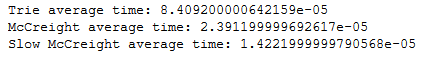

example 2 - aabbabd

In [16]:
text = "aabbabd"
time_eval(left_to_right, [text], True, "Trie",count=50)
time_eval(McCreight, [text], True, "McCreight",count=50)
time_eval(SlowMcCreight, [text], True, "Slow McCreight",count=50)

Trie average time: 0.00023779799999999794
McCreight average time: 2.0768000000011e-05
Slow McCreight average time: 2.3642000000023698e-05


Saved results
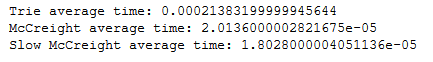

example 3 - ababcd

In [17]:
text = "ababcd"
time_eval(left_to_right, [text], True, "Trie")
time_eval(McCreight, [text], True, "McCreight")
time_eval(SlowMcCreight, [text], True, "Slow McCreight")

Trie average time: 0.00014215999999986906
McCreight average time: 1.6149999999903743e-05
Slow McCreight average time: 3.007999999997679e-05


Saved results
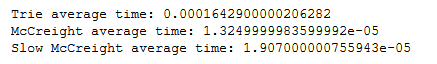

example 4 - abcbccd

In [20]:
text = "abcbccd"
time_eval(left_to_right, [text], True, "Trie")
time_eval(McCreight, [text], True, "McCreight")
time_eval(SlowMcCreight, [text], True, "Slow McCreight")

Trie average time: 0.00019513000000017655
McCreight average time: 1.5370000000558547e-05
Slow McCreight average time: 1.902999999998656e-05


Saved results
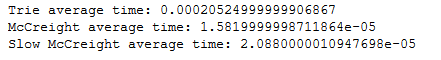

In [19]:
f = open("1997_714.txt", "r", encoding='utf-8')
text = ''.join(f.readlines())
text = text[:2000]
text += chr(27) # unique character at the end
time_eval(left_to_right, [text], True, "Trie", count=1)
time_eval(McCreight, [text], True, "McCreight", 1)
time_eval(SlowMcCreight, [text], True, "Slow McCreight", 1)


Trie average time: 9.129483400000002
McCreight average time: 0.007633300000001952
Slow McCreight average time: 0.022145499999997043


Screen of results when len(text)=2000
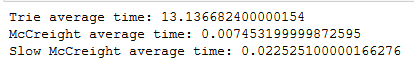